# Importing Required Libraries

In [1]:
import os
import torch
import pickle
from datasets import load_dataset
import random
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms.functional import pil_to_tensor, to_pil_image

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Makeing Results Reproducible

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Reading the Dataset


In [4]:
data = load_dataset('./tiny-imagenet', split='train')
test = load_dataset('./tiny-imagenet', split='valid')

In [5]:
print(data)
print(test)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [6]:
def get_tensor_data(data):
    tensor_images_list = [pil_to_tensor(img).to(torch.float32) for img in data["image"]]
    tensor_labels = data["label"]
    remove_indices = []

    for i in range(len(tensor_images_list)):
        if tensor_images_list[i].shape != (3, 64, 64):
            remove_indices.append(i)

    for i in range(len(remove_indices) - 1, -1, -1):
        tensor_images_list.pop(remove_indices[i])
        tensor_labels.pop(remove_indices[i])

    print("No of images =", len(tensor_images_list))
    print("No of labels =", len(tensor_labels))
    print("No of removed images =", len(remove_indices))

    return torch.stack(tensor_images_list, dim=0) / 255, torch.tensor(tensor_labels)

In [7]:
data_images, data_labels = get_tensor_data(data)
test_images, test_labels = get_tensor_data(test)

No of images = 98179
No of labels = 98179
No of removed images = 1821
No of images = 9832
No of labels = 9832
No of removed images = 168


# Showing examples from datasets for sanity checking

In [8]:
def show_example(image, label):
  print("Label :", label.item())
  pyplot.imshow(to_pil_image(image))

index = 23582
Label : 47


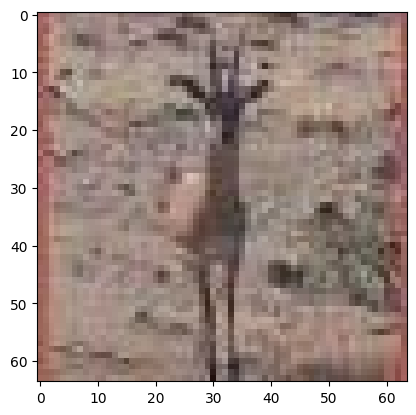

In [9]:
index = random.randint(0, 98179)
print("index =", index)
show_example(data_images[index], data_labels[index])

index = 3649
Label : 73


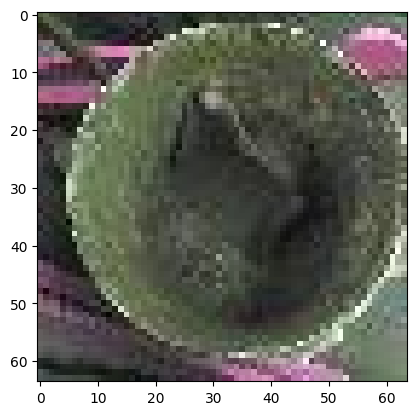

In [10]:
index = random.randint(0, 9832)
print("index =", index)
show_example(test_images[index], test_labels[index])

# Train - Validation set split

In [11]:
train_examples = 90000
validation_examples = 8179

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


dataset = CustomDataset(data_images, data_labels)
train, validation = random_split(dataset, [train_examples, validation_examples])
testset = CustomDataset(test_images, test_labels)

# Defining the Models

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
    self.batch1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
    self.batch2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.batch3 = nn.BatchNorm2d(256)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.batch4 = nn.BatchNorm2d(512)

    self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
    self.batch5 = nn.BatchNorm2d(1024)

    self.maxpool = nn.MaxPool2d(2, 2)
    self.avgpool = nn.AvgPool2d(4, 4)
    self.relu = nn.PReLU()
    self.drop1 = nn.Dropout(0.33)
    self.drop2 = nn.Dropout2d(0.25)

    self.fc1 = nn.Linear(1024, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 200)

  def forward(self, x):
    # x.shape = (B x 3 x 64 x 64)

    x1 = self.batch1(self.conv1(x)) # x1.shape = (B x 64 x 64 x 64)
    x = self.maxpool(self.drop2(self.relu(x1)))
    # x.shape = (B x 64 x 32 x 32)

    x2 = self.batch2(self.conv2(x)) # x2.shape = (B x 128 x 32 x 32)
    x = self.maxpool(self.relu(x2))
    # x.shape = (B x 128 x 16 x 16)

    x3 = self.batch3(self.conv3(x)) # x3.shape = (B x 256 x 16 x 16)
    x = self.maxpool(self.drop2(self.relu(x3)))
    # x.shape = (B x 256 x 8 x 8)

    x4 = self.batch4(self.conv4(x)) # x4.shape = (B x 512 x 8 x 8)
    x = self.maxpool(self.relu(x4))
    # x.shape = (B x 512 x 4 x 4)

    x5 = self.drop2(self.relu(self.batch5(self.conv5(x)))) # x5.shape = (B x 1024 x 4 x 4)
    x = self.avgpool(x5)
    # x.shape = (B x 1024 x 1 x 1)

    x = torch.flatten(x, 1) 
    # flatten all dimensions except batch (0th dim)

    x = self.relu(self.fc1(x))
    x = self.drop1(self.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

In [13]:
model = CNN().to(device)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
             PReLU-3           [-1, 64, 64, 64]               1
         Dropout2d-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]         204,928
       BatchNorm2d-7          [-1, 128, 32, 32]             256
             PReLU-8          [-1, 128, 32, 32]               1
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
            PReLU-12          [-1, 256, 16, 16]               1
        Dropout2d-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

# Helper Functions to Train and Test the Model

In [14]:
def validatioon_step(model, validation_loader, loss_function):
    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    with torch.no_grad():
      for j, (x_val, y_val) in enumerate(validation_loader):
        x_val = x_val.to(device)
        y_val = y_val.long().to(device)

        y_pred = model(x_val)
        loss = loss_function(y_pred, y_val)

        _, predicted = torch.max(y_pred.data, dim=1)
        validation_correct += (predicted == y_val).sum().item()

        validation_loss += loss.item()

    return validation_loss, validation_correct


In [15]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    correct_top5 = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            _, predicted_top5 = torch.topk(outputs.data, k=5, dim=1, largest=True, sorted=True)
            predicted_top5 = predicted_top5.t()

            for i in range(5):
                correct_top5 += (predicted_top5[i] == labels).sum().item()

    return 100 * correct / total, 100 * correct_top5 / total

In [16]:
def fit(model, optimizer_fn, scheduler_fn, loss_fn, train_loader, validation_loader, test_loader, learning_rate, num_epochs):
  history = []
  accuracies = {"top1": [], "top5" : []}
  optimizer = optimizer_fn(model.parameters(), learning_rate)
  scheduler = scheduler_fn(optimizer, step_size = 10, gamma = 0.5)
  
  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.long().to(device)

      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      _, predicted = torch.max(y_pred.data, dim=1)
      train_correct += (predicted == y_batch).sum().item()
      train_loss += loss.item()

    validation_loss, validation_correct = validatioon_step(model, validation_loader, loss_fn)
    scheduler.step()

    if ((epoch + 1) % 5) == 0:
      accuracy1, accuracy5 = evaluate(model, test_loader)
      print("Test accuracy after", epoch+1, "epochs is =", accuracy1, accuracy5)
      accuracies["top1"].append(accuracy1)
      accuracies["top5"].append(accuracy5)

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss, "\tValidation Loss :", validation_loss)
    history.append({"train_loss" : train_loss/train_examples,
                    "validation_loss" : validation_loss/validation_examples,
                    "train_accuracy" : 100*train_correct/train_examples,
                    "validation_accuracy" : 100*validation_correct/validation_examples})

  return history, accuracies

In [17]:
def plot_losses(history):
  train_losses = []
  validation_losses = []

  for result in history:
    train_losses.append(result["train_loss"])
    validation_losses.append(result["validation_loss"])

  pyplot.plot(train_losses, '-bx')
  pyplot.plot(validation_losses, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs')

In [18]:
def plot_accuracies(history):
  train_accuracies = []
  validation_accuracies = []

  for result in history:
    train_accuracies.append(result["train_accuracy"])
    validation_accuracies.append(result["validation_accuracy"])

  pyplot.plot(train_accuracies, '-bx')
  pyplot.plot(validation_accuracies, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Acurracy vs. No. of epochs')

# Training the models

In [19]:
model = CNN().to(device)

train_loader = DataLoader(train, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation, batch_size=256, shuffle=True)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)
optimizer = torch.optim.AdamW
loss_function = F.cross_entropy
scheduler = torch.optim.lr_scheduler.StepLR

history, accuracies = fit(model, optimizer, scheduler, loss_function, train_loader, validation_loader, test_loader, learning_rate=0.02, num_epochs=100)

  1%|          | 1/100 [00:22<36:49, 22.32s/it]

Epoch 1 -	Training Loss : 5720.086560249329 	Validation Loss : 168.90329933166504


  2%|▏         | 2/100 [00:44<36:10, 22.14s/it]

Epoch 2 -	Training Loss : 3661.994176387787 	Validation Loss : 162.68686389923096


  3%|▎         | 3/100 [01:06<35:59, 22.27s/it]

Epoch 3 -	Training Loss : 3575.1039295196533 	Validation Loss : 160.59744882583618


  4%|▍         | 4/100 [01:28<35:29, 22.18s/it]

Epoch 4 -	Training Loss : 3491.670407295227 	Validation Loss : 153.43617391586304


  5%|▌         | 5/100 [01:52<35:45, 22.59s/it]

Test accuracy after 5 epochs is = 4.129373474369406 15.378356387306754
Epoch 5 -	Training Loss : 3407.5571146011353 	Validation Loss : 151.65121412277222


  6%|▌         | 6/100 [02:14<35:06, 22.41s/it]

Epoch 6 -	Training Loss : 3334.959846973419 	Validation Loss : 147.312979221344


  7%|▋         | 7/100 [02:36<34:35, 22.31s/it]

Epoch 7 -	Training Loss : 3266.981360912323 	Validation Loss : 145.41827583312988


  8%|▊         | 8/100 [02:58<34:23, 22.43s/it]

Epoch 8 -	Training Loss : 3224.0363550186157 	Validation Loss : 144.09244632720947


  9%|▉         | 9/100 [03:23<35:08, 23.17s/it]

Epoch 9 -	Training Loss : 3184.1661281585693 	Validation Loss : 138.3070788383484


 10%|█         | 10/100 [03:50<36:13, 24.15s/it]

Test accuracy after 10 epochs is = 7.872253864930838 25.691619202603743
Epoch 10 -	Training Loss : 3133.046148300171 	Validation Loss : 139.44238901138306


 11%|█         | 11/100 [04:15<36:25, 24.56s/it]

Epoch 11 -	Training Loss : 2935.067460536957 	Validation Loss : 128.16047859191895


 12%|█▏        | 12/100 [04:40<36:11, 24.68s/it]

Epoch 12 -	Training Loss : 2870.8574562072754 	Validation Loss : 126.00382161140442


 13%|█▎        | 13/100 [05:03<34:57, 24.11s/it]

Epoch 13 -	Training Loss : 2826.4845292568207 	Validation Loss : 125.47510099411011


 14%|█▍        | 14/100 [05:26<34:05, 23.79s/it]

Epoch 14 -	Training Loss : 2785.707574367523 	Validation Loss : 124.26918244361877


 15%|█▌        | 15/100 [05:50<33:38, 23.74s/it]

Test accuracy after 15 epochs is = 15.703824247355573 40.14442636289667
Epoch 15 -	Training Loss : 2740.2261123657227 	Validation Loss : 122.85170531272888


 16%|█▌        | 16/100 [06:12<32:49, 23.45s/it]

Epoch 16 -	Training Loss : 2708.8409039974213 	Validation Loss : 129.2308804988861


 17%|█▋        | 17/100 [06:35<32:01, 23.15s/it]

Epoch 17 -	Training Loss : 2664.6077539920807 	Validation Loss : 122.58216190338135


 18%|█▊        | 18/100 [06:57<31:24, 22.98s/it]

Epoch 18 -	Training Loss : 2631.864860534668 	Validation Loss : 112.90677213668823


 19%|█▉        | 19/100 [07:20<30:46, 22.79s/it]

Epoch 19 -	Training Loss : 2610.19322681427 	Validation Loss : 120.95691800117493


 20%|██        | 20/100 [07:43<30:31, 22.89s/it]

Test accuracy after 20 epochs is = 15.886899918633034 38.934092758340114
Epoch 20 -	Training Loss : 2580.167620420456 	Validation Loss : 124.06930446624756


 21%|██        | 21/100 [08:05<29:46, 22.61s/it]

Epoch 21 -	Training Loss : 2416.123949766159 	Validation Loss : 106.10691809654236


 22%|██▏       | 22/100 [08:27<29:13, 22.48s/it]

Epoch 22 -	Training Loss : 2362.404590368271 	Validation Loss : 103.48621797561646


 23%|██▎       | 23/100 [08:49<28:35, 22.28s/it]

Epoch 23 -	Training Loss : 2322.8210067749023 	Validation Loss : 103.19972801208496


 24%|██▍       | 24/100 [09:11<28:09, 22.23s/it]

Epoch 24 -	Training Loss : 2298.160480737686 	Validation Loss : 102.60188102722168


 25%|██▌       | 25/100 [09:34<27:57, 22.37s/it]

Test accuracy after 25 epochs is = 26.617168429617575 54.200569568755085
Epoch 25 -	Training Loss : 2268.690693616867 	Validation Loss : 103.12888407707214


 26%|██▌       | 26/100 [09:55<27:20, 22.17s/it]

Epoch 26 -	Training Loss : 2246.0944747924805 	Validation Loss : 103.93929862976074


 27%|██▋       | 27/100 [10:17<26:53, 22.10s/it]

Epoch 27 -	Training Loss : 2221.5111503601074 	Validation Loss : 100.8374650478363


 28%|██▊       | 28/100 [10:39<26:23, 21.99s/it]

Epoch 28 -	Training Loss : 2198.1209783554077 	Validation Loss : 101.57517695426941


 29%|██▉       | 29/100 [11:01<26:00, 21.98s/it]

Epoch 29 -	Training Loss : 2173.7291872501373 	Validation Loss : 104.93293929100037


 30%|███       | 30/100 [11:24<25:57, 22.24s/it]

Test accuracy after 30 epochs is = 27.92921074043938 54.83116354759967
Epoch 30 -	Training Loss : 2150.1741197109222 	Validation Loss : 102.93571591377258


 31%|███       | 31/100 [11:45<25:21, 22.05s/it]

Epoch 31 -	Training Loss : 2032.188322544098 	Validation Loss : 98.05139255523682


 32%|███▏      | 32/100 [12:07<24:58, 22.03s/it]

Epoch 32 -	Training Loss : 1983.6595792770386 	Validation Loss : 95.43311929702759


 33%|███▎      | 33/100 [12:29<24:34, 22.01s/it]

Epoch 33 -	Training Loss : 1956.6440181732178 	Validation Loss : 95.77155327796936


 34%|███▍      | 34/100 [12:51<24:05, 21.90s/it]

Epoch 34 -	Training Loss : 1935.7020123004913 	Validation Loss : 94.3808946609497


 35%|███▌      | 35/100 [13:14<24:04, 22.22s/it]

Test accuracy after 35 epochs is = 31.51952807160293 59.62164361269325
Epoch 35 -	Training Loss : 1915.745771408081 	Validation Loss : 94.21788239479065


 36%|███▌      | 36/100 [13:36<23:38, 22.16s/it]

Epoch 36 -	Training Loss : 1890.1945419311523 	Validation Loss : 96.26779747009277


 37%|███▋      | 37/100 [13:58<23:08, 22.04s/it]

Epoch 37 -	Training Loss : 1869.9204003810883 	Validation Loss : 93.66699576377869


 38%|███▊      | 38/100 [14:20<22:46, 22.04s/it]

Epoch 38 -	Training Loss : 1846.007717847824 	Validation Loss : 93.56864356994629


 39%|███▉      | 39/100 [14:42<22:22, 22.00s/it]

Epoch 39 -	Training Loss : 1828.9344930648804 	Validation Loss : 92.06612467765808


 40%|████      | 40/100 [15:04<22:09, 22.16s/it]

Test accuracy after 40 epochs is = 33.014646053702194 60.1606997558991
Epoch 40 -	Training Loss : 1802.7435965538025 	Validation Loss : 94.81195735931396


 41%|████      | 41/100 [15:26<21:43, 22.10s/it]

Epoch 41 -	Training Loss : 1712.7716989517212 	Validation Loss : 90.39407014846802


 42%|████▏     | 42/100 [15:48<21:13, 21.96s/it]

Epoch 42 -	Training Loss : 1679.4299384355545 	Validation Loss : 89.96704244613647


 43%|████▎     | 43/100 [16:10<20:51, 21.95s/it]

Epoch 43 -	Training Loss : 1658.289069056511 	Validation Loss : 90.96767711639404


 44%|████▍     | 44/100 [16:32<20:27, 21.92s/it]

Epoch 44 -	Training Loss : 1633.6827882528305 	Validation Loss : 89.85845375061035


 45%|████▌     | 45/100 [16:54<20:18, 22.16s/it]

Test accuracy after 45 epochs is = 34.804719283970705 62.30675345809601
Epoch 45 -	Training Loss : 1616.5365853309631 	Validation Loss : 90.7595546245575


 46%|████▌     | 46/100 [17:16<19:54, 22.13s/it]

Epoch 46 -	Training Loss : 1594.819669008255 	Validation Loss : 92.29679322242737


 47%|████▋     | 47/100 [17:38<19:28, 22.05s/it]

Epoch 47 -	Training Loss : 1573.216831445694 	Validation Loss : 90.11658000946045


 48%|████▊     | 48/100 [18:00<19:06, 22.04s/it]

Epoch 48 -	Training Loss : 1554.0862090587616 	Validation Loss : 90.19641613960266


 49%|████▉     | 49/100 [18:22<18:44, 22.05s/it]

Epoch 49 -	Training Loss : 1536.472529053688 	Validation Loss : 89.26788640022278


 50%|█████     | 50/100 [18:46<18:46, 22.52s/it]

Test accuracy after 50 epochs is = 36.625305126118796 64.05614320585842
Epoch 50 -	Training Loss : 1511.2895404100418 	Validation Loss : 88.88296937942505


 51%|█████     | 51/100 [19:09<18:28, 22.62s/it]

Epoch 51 -	Training Loss : 1447.910758972168 	Validation Loss : 89.96114444732666


 52%|█████▏    | 52/100 [19:31<18:05, 22.62s/it]

Epoch 52 -	Training Loss : 1421.9823439121246 	Validation Loss : 89.36905980110168


 53%|█████▎    | 53/100 [19:54<17:45, 22.66s/it]

Epoch 53 -	Training Loss : 1403.7832182645798 	Validation Loss : 90.40042543411255


 54%|█████▍    | 54/100 [20:17<17:22, 22.66s/it]

Epoch 54 -	Training Loss : 1388.0362002849579 	Validation Loss : 90.24513554573059


 55%|█████▌    | 55/100 [20:40<17:13, 22.96s/it]

Test accuracy after 55 epochs is = 37.57119609438568 64.95117982099268
Epoch 55 -	Training Loss : 1372.0469378232956 	Validation Loss : 89.40912747383118


 56%|█████▌    | 56/100 [21:03<16:48, 22.92s/it]

Epoch 56 -	Training Loss : 1358.0793014764786 	Validation Loss : 89.27032160758972


 57%|█████▋    | 57/100 [21:26<16:27, 22.96s/it]

Epoch 57 -	Training Loss : 1343.0265662670135 	Validation Loss : 89.2995252609253


 58%|█████▊    | 58/100 [21:49<16:02, 22.92s/it]

Epoch 58 -	Training Loss : 1327.239983201027 	Validation Loss : 90.40067434310913


 59%|█████▉    | 59/100 [22:12<15:37, 22.87s/it]

Epoch 59 -	Training Loss : 1313.3158912658691 	Validation Loss : 90.48592615127563


 60%|██████    | 60/100 [22:36<15:24, 23.12s/it]

Test accuracy after 60 epochs is = 38.018714401952806 65.14442636289667
Epoch 60 -	Training Loss : 1298.264096736908 	Validation Loss : 89.19198560714722


 61%|██████    | 61/100 [22:58<14:54, 22.95s/it]

Epoch 61 -	Training Loss : 1254.840476512909 	Validation Loss : 90.39996433258057


 62%|██████▏   | 62/100 [23:21<14:27, 22.83s/it]

Epoch 62 -	Training Loss : 1239.1311161518097 	Validation Loss : 90.77960157394409


 63%|██████▎   | 63/100 [23:43<13:59, 22.69s/it]

Epoch 63 -	Training Loss : 1229.3529646396637 	Validation Loss : 90.82478165626526


 64%|██████▍   | 64/100 [24:05<13:32, 22.56s/it]

Epoch 64 -	Training Loss : 1216.0635237693787 	Validation Loss : 89.2648196220398


 65%|██████▌   | 65/100 [24:28<13:11, 22.61s/it]

Test accuracy after 65 epochs is = 39.10699755899105 66.1106590724166
Epoch 65 -	Training Loss : 1207.0220999717712 	Validation Loss : 89.47285842895508


 66%|██████▌   | 66/100 [24:50<12:42, 22.44s/it]

Epoch 66 -	Training Loss : 1198.7796621322632 	Validation Loss : 90.50006699562073


 67%|██████▋   | 67/100 [25:12<12:15, 22.28s/it]

Epoch 67 -	Training Loss : 1189.4146338701248 	Validation Loss : 90.40871620178223


 68%|██████▊   | 68/100 [25:34<11:49, 22.18s/it]

Epoch 68 -	Training Loss : 1180.506100177765 	Validation Loss : 89.77324414253235


 69%|██████▉   | 69/100 [25:56<11:25, 22.12s/it]

Epoch 69 -	Training Loss : 1170.6163408756256 	Validation Loss : 89.43808388710022


 70%|███████   | 70/100 [26:19<11:08, 22.28s/it]

Test accuracy after 70 epochs is = 39.381611065907244 66.25305126118796
Epoch 70 -	Training Loss : 1161.611699104309 	Validation Loss : 89.64064073562622


 71%|███████   | 71/100 [26:40<10:39, 22.05s/it]

Epoch 71 -	Training Loss : 1136.2272808551788 	Validation Loss : 88.71114039421082


 72%|███████▏  | 72/100 [27:02<10:16, 22.04s/it]

Epoch 72 -	Training Loss : 1129.6487934589386 	Validation Loss : 89.96096134185791


 73%|███████▎  | 73/100 [27:24<09:50, 21.88s/it]

Epoch 73 -	Training Loss : 1121.667722582817 	Validation Loss : 89.83332347869873


 74%|███████▍  | 74/100 [27:45<09:28, 21.85s/it]

Epoch 74 -	Training Loss : 1113.0725877285004 	Validation Loss : 90.02110981941223


 75%|███████▌  | 75/100 [28:08<09:12, 22.11s/it]

Test accuracy after 75 epochs is = 39.16802278275021 66.24288039056144
Epoch 75 -	Training Loss : 1107.8384610414505 	Validation Loss : 89.96257019042969


 76%|███████▌  | 76/100 [28:31<08:54, 22.26s/it]

Epoch 76 -	Training Loss : 1105.7433001995087 	Validation Loss : 90.2519896030426


 77%|███████▋  | 77/100 [28:53<08:33, 22.34s/it]

Epoch 77 -	Training Loss : 1099.3963735103607 	Validation Loss : 91.2739646434784


 78%|███████▊  | 78/100 [29:16<08:13, 22.42s/it]

Epoch 78 -	Training Loss : 1096.1027159690857 	Validation Loss : 90.55023980140686


 79%|███████▉  | 79/100 [29:39<07:52, 22.50s/it]

Epoch 79 -	Training Loss : 1089.4077240228653 	Validation Loss : 91.23488879203796


 80%|████████  | 80/100 [30:02<07:36, 22.82s/it]

Test accuracy after 80 epochs is = 39.218877135882835 65.88689991863303
Epoch 80 -	Training Loss : 1080.0760046243668 	Validation Loss : 90.03673911094666


 81%|████████  | 81/100 [30:25<07:12, 22.77s/it]

Epoch 81 -	Training Loss : 1071.87216258049 	Validation Loss : 91.20360469818115


 82%|████████▏ | 82/100 [30:48<06:49, 22.77s/it]

Epoch 82 -	Training Loss : 1068.555433511734 	Validation Loss : 90.66095423698425


 83%|████████▎ | 83/100 [31:10<06:27, 22.81s/it]

Epoch 83 -	Training Loss : 1062.8156759738922 	Validation Loss : 91.21964406967163


 84%|████████▍ | 84/100 [31:33<06:04, 22.75s/it]

Epoch 84 -	Training Loss : 1060.8378621339798 	Validation Loss : 90.89558744430542


 85%|████████▌ | 85/100 [31:57<05:45, 23.01s/it]

Test accuracy after 85 epochs is = 39.462978030919444 65.88689991863303
Epoch 85 -	Training Loss : 1054.6673719882965 	Validation Loss : 91.42520046234131


 86%|████████▌ | 86/100 [32:19<05:20, 22.90s/it]

Epoch 86 -	Training Loss : 1053.219179391861 	Validation Loss : 91.6181206703186


 87%|████████▋ | 87/100 [32:42<04:56, 22.77s/it]

Epoch 87 -	Training Loss : 1050.1691179275513 	Validation Loss : 90.93508839607239


 88%|████████▊ | 88/100 [33:05<04:33, 22.81s/it]

Epoch 88 -	Training Loss : 1044.0987792015076 	Validation Loss : 91.07513070106506


 89%|████████▉ | 89/100 [33:27<04:10, 22.78s/it]

Epoch 89 -	Training Loss : 1040.1009018421173 	Validation Loss : 91.76638770103455


 90%|█████████ | 90/100 [33:51<03:50, 23.03s/it]

Test accuracy after 90 epochs is = 39.53417412530513 66.12082994304312
Epoch 90 -	Training Loss : 1045.0268378257751 	Validation Loss : 91.59675645828247


 91%|█████████ | 91/100 [34:14<03:26, 22.92s/it]

Epoch 91 -	Training Loss : 1038.9041455984116 	Validation Loss : 91.61333703994751


 92%|█████████▏| 92/100 [34:36<03:01, 22.74s/it]

Epoch 92 -	Training Loss : 1031.0842189788818 	Validation Loss : 91.09169697761536


 93%|█████████▎| 93/100 [34:59<02:38, 22.68s/it]

Epoch 93 -	Training Loss : 1036.5694885253906 	Validation Loss : 91.1422209739685


 94%|█████████▍| 94/100 [35:21<02:16, 22.67s/it]

Epoch 94 -	Training Loss : 1030.7817550897598 	Validation Loss : 91.530118227005


 95%|█████████▌| 95/100 [35:44<01:54, 22.87s/it]

Test accuracy after 95 epochs is = 39.493490642799024 65.95809601301872
Epoch 95 -	Training Loss : 1025.7151590585709 	Validation Loss : 91.45682144165039


 96%|█████████▌| 96/100 [36:07<01:30, 22.75s/it]

Epoch 96 -	Training Loss : 1028.869767665863 	Validation Loss : 91.94370102882385


 97%|█████████▋| 97/100 [36:29<01:07, 22.62s/it]

Epoch 97 -	Training Loss : 1024.1175899505615 	Validation Loss : 91.65433669090271


 98%|█████████▊| 98/100 [36:52<00:45, 22.52s/it]

Epoch 98 -	Training Loss : 1030.0082738399506 	Validation Loss : 91.37797617912292


 99%|█████████▉| 99/100 [37:14<00:22, 22.41s/it]

Epoch 99 -	Training Loss : 1021.843386888504 	Validation Loss : 91.86953854560852


100%|██████████| 100/100 [37:37<00:00, 22.57s/it]

Test accuracy after 100 epochs is = 39.493490642799024 65.98860862489829
Epoch 100 -	Training Loss : 1021.389520406723 	Validation Loss : 91.99855828285217


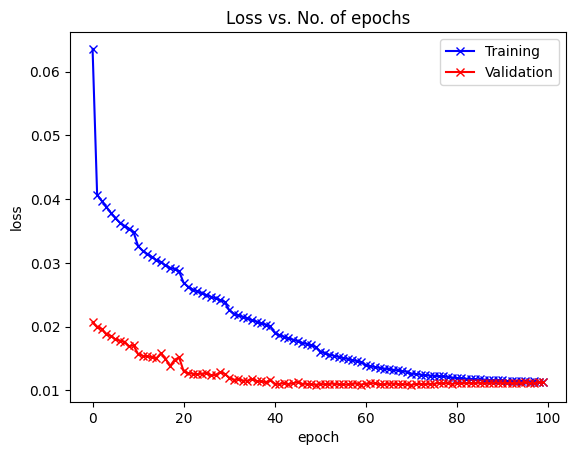

In [20]:
plot_losses(history)

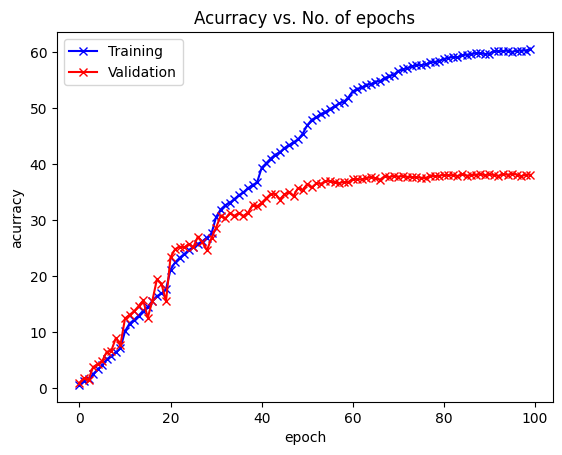

In [21]:
plot_accuracies(history)

In [22]:
print(accuracies)

{'top1': [4.129373474369406, 7.872253864930838, 15.703824247355573, 15.886899918633034, 26.617168429617575, 27.92921074043938, 31.51952807160293, 33.014646053702194, 34.804719283970705, 36.625305126118796, 37.57119609438568, 38.018714401952806, 39.10699755899105, 39.381611065907244, 39.16802278275021, 39.218877135882835, 39.462978030919444, 39.53417412530513, 39.493490642799024, 39.493490642799024], 'top5': [15.378356387306754, 25.691619202603743, 40.14442636289667, 38.934092758340114, 54.200569568755085, 54.83116354759967, 59.62164361269325, 60.1606997558991, 62.30675345809601, 64.05614320585842, 64.95117982099268, 65.14442636289667, 66.1106590724166, 66.25305126118796, 66.24288039056144, 65.88689991863303, 65.88689991863303, 66.12082994304312, 65.95809601301872, 65.98860862489829]}


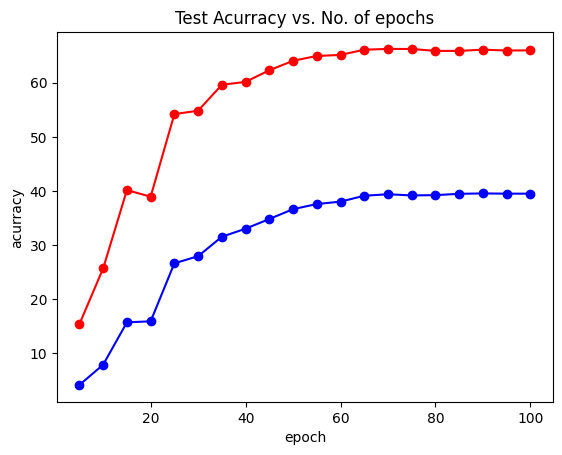

In [23]:
epochs = [i for i in range(5, 101, 5)]
pyplot.plot(epochs, accuracies["top1"], '-bo')
pyplot.plot(epochs, accuracies["top5"], '-ro')
pyplot.xlabel('epoch')
pyplot.ylabel('acurracy')
pyplot.title('Test Acurracy vs. No. of epochs')
pyplot.show()